In [166]:
# Download annotations from Butler using docai library
# AnnotaionClient module for Butler with the specific API
from docai.annotations import AnnotationClient
from docai.generated.models import ModelTrainingDocumentStatus

# Get your API Key from Butler
API_KEY = ""

# Specify the id of the model that you annotated your documents in
MODEL_ID = ""

# Load annotations from Butler
butler_client = AnnotationClient(API_KEY)
annotations = butler_client.load_annotations(
    model_id=MODEL_ID, 
    load_all_pages=True,
    document_status=ModelTrainingDocumentStatus.LABELED
)
print("Loaded {} annotations".format(len(annotations.training_documents)))

Loaded 44 annotations


### LMV3 basato su transformers che consentono al modello di elaborare sequenze di parole e cogliere relazioni complesse tra di esse. 
I transformers sono un tipo di architettura di reti neurali ricorrenti (RNN) che si sono dimostrate molto efficaci nel campo del processing del linguaggio naturale (NLP) e in altri compiti di elaborazione delle sequenze. Questa architettura è stata introdotta per la prima volta nel 2017 con il modello "Transformer" presentato nel paper "Attention is All You Need" da Vaswani et al.
A differenza delle reti neurali ricorrenti tradizionali, i transformers non dipendono da strutture di tipo sequenziale come le LSTM o le GRU, ma si basano sull'uso di meccanismi di attenzione per catturare le relazioni tra le parole o gli elementi di una sequenza.
La struttura di base di un transformer è composta da due componenti principali: l'encoder e il decoder. L'encoder elabora l'input di una sequenza di parole o elementi estraendo informazioni contestuali da ciascun elemento, mentre il decoder genera una sequenza di output basata sull'output dell'encoder e su una rappresentazione interna chiamata "attenzione".
Ogni componente del transformer è composto da diversi strati. All'interno di ogni strato, ci sono due sottocomponenti principali: il meccanismo di attenzione multi-head e la rete feed-forward.
Il meccanismo di attenzione multi-head consente al modello di considerare le relazioni tra le parole o gli elementi in modo non sequenziale, assegnando un peso a ciascun elemento della sequenza in base alla sua rilevanza per gli altri elementi. Ciò consente di catturare le dipendenze a lungo termine tra le parole e di prestare attenzione a diverse parti del contesto.
La rete feed-forward, invece, applica trasformazioni lineari e funzioni di attivazione non lineari agli output dell'attenzione per creare rappresentazioni contestuali dei token.
Un aspetto chiave dei transformers è che l'attenzione è calcolata in parallelo per tutti gli elementi della sequenza, rendendo possibile l'elaborazione altamente parallela, a differenza delle RNN che richiedono l'elaborazione sequenziale.
Inoltre, i transformers possono essere arricchiti con strati aggiuntivi come l'attenzione residua, la normalizzazione del batch e gli strati di output completamente connessi per migliorare la stabilità del training e l'espressività del modello.
I transformers hanno dimostrato prestazioni eccezionali in una vasta gamma di compiti NLP, come traduzione automatica, generazione di testo, classificazione del linguaggio, riassunto del testo e molto altro ancora. La loro capacità di catturare relazioni complesse e di elaborare sequenze di lunghezza variabile ha contribuito al loro successo nell'ambito del processing del linguaggio naturale.

In [167]:
from docai.annotations import normalize_ner_annotation_for_layoutlm

# Convert annotations into NER format so they can be used
# to train LayoutLMv3 with Hugging Face
annotations_as_ner = annotations.as_ner(as_iob2=True)

# Normalize NER annotations by 1000 to match LayoutLM expected bounding box format
annotations_as_ner = list(map(normalize_ner_annotation_for_layoutlm, annotations_as_ner))

In [168]:
# Create Hugging Face Dataset
from datasets import Dataset
dataset = Dataset.from_list(annotations_as_ner)
print(dataset)

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 44
})


In [169]:
# First, lets create a few helper variables for use below
from datasets.features import ClassLabel
from docai.annotations import get_ner_tags_for_model

model_ner_tags = get_ner_tags_for_model(annotations.model_details)
print(f'Tags: {model_ner_tags["tags"]}')

label_list = model_ner_tags["tags"]
class_label = ClassLabel(names=label_list)
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
column_names = dataset.column_names

# Split dataset into train/test
dataset = dataset.train_test_split(test_size=0.2)

Tags: ['O', 'B-Date', 'B-Dear', 'B-code', 'B-text', 'I-Date', 'I-Dear', 'I-code', 'I-text']


In [174]:
# Load the microsoft/layoutlmv3-base processor from the Hugging Face hub
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def convert_ner_tags_to_id(ner_tags):
  return [label2id[ner_tag] for ner_tag in ner_tags]

# This function is used to put the Dataset in its final format for training LayoutLM
def prepare_dataset(annotations):
    images = annotations['image']
    words = annotations['tokens']
    boxes = annotations['bboxes']
    # Map over labels and convert to numeric id for each ner_tag
    ner_tags = [convert_ner_tags_to_id(ner_tags) for ner_tags in annotations['ner_tags']]

    encoding = processor(images, words, boxes=boxes, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

OSError: microsoft/layoutlmv3-base does not appear to have a file named config.json. Checkout 'https://huggingface.co/microsoft/layoutlmv3-base/None' for available files.

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Define features for use training the model 
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Prepare our train & eval dataset
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
from docai.training import generate_layoutlm_compute_eval_metric_fn

# Use this utility from the docai SDK to create a function that can
# be used to calculate the evaluation metrics while training
compute_eval_metrics = generate_layoutlm_compute_eval_metric_fn(
    ner_labels=label_list,
    metric_name="seqeval",
    return_entity_level_metrics=False
)

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator

MODEL_NAME = 'letter_model_new'

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id)

training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_eval_metrics
)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.2988418936729431, 'eval_precision': 0.8260869565217391, 'eval_recall': 0.95, 'eval_f1': 0.8837209302325583, 'eval_accuracy': 0.9620081411126187, 'eval_runtime': 3.0692, 'eval_samples_per_second': 1.629, 'eval_steps_per_second': 0.977, 'epoch': 10.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.43064045906066895, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9538670284938942, 'eval_runtime': 3.154, 'eval_samples_per_second': 1.585, 'eval_steps_per_second': 0.951, 'epoch': 20.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.29263195395469666, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.966078697421981, 'eval_runtime': 2.7904, 'eval_samples_per_second': 1.792, 'eval_steps_per_second': 1.075, 'epoch': 30.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.47968196868896484, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9525101763907734, 'eval_runtime': 2.969, 'eval_samples_per_second': 1.684, 'eval_steps_per_second': 1.01, 'epoch': 40.0}
{'loss': 0.0658, 'learning_rate': 5e-06, 'epoch': 50.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.47593897581100464, 'eval_precision': 0.8333333333333334, 'eval_recall': 1.0, 'eval_f1': 0.9090909090909091, 'eval_accuracy': 0.9497964721845319, 'eval_runtime': 2.9177, 'eval_samples_per_second': 1.714, 'eval_steps_per_second': 1.028, 'epoch': 50.0}


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.5228825807571411, 'eval_precision': 0.8333333333333334, 'eval_recall': 1.0, 'eval_f1': 0.9090909090909091, 'eval_accuracy': 0.9497964721845319, 'eval_runtime': 2.9644, 'eval_samples_per_second': 1.687, 'eval_steps_per_second': 1.012, 'epoch': 60.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.4259318709373474, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9606512890094979, 'eval_runtime': 2.8421, 'eval_samples_per_second': 1.759, 'eval_steps_per_second': 1.056, 'epoch': 70.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.4251485764980316, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9606512890094979, 'eval_runtime': 2.7656, 'eval_samples_per_second': 1.808, 'eval_steps_per_second': 1.085, 'epoch': 80.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.4243151545524597, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9606512890094979, 'eval_runtime': 2.9726, 'eval_samples_per_second': 1.682, 'eval_steps_per_second': 1.009, 'epoch': 90.0}
{'loss': 0.0008, 'learning_rate': 0.0, 'epoch': 100.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.4285721182823181, 'eval_precision': 0.8695652173913043, 'eval_recall': 1.0, 'eval_f1': 0.9302325581395349, 'eval_accuracy': 0.9606512890094979, 'eval_runtime': 2.9141, 'eval_samples_per_second': 1.716, 'eval_steps_per_second': 1.029, 'epoch': 100.0}
{'train_runtime': 4335.9442, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.231, 'train_loss': 0.033276002138853074, 'epoch': 100.0}


TrainOutput(global_step=1000, training_loss=0.033276002138853074, metrics={'train_runtime': 4335.9442, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.231, 'train_loss': 0.033276002138853074, 'epoch': 100.0})

In [175]:
from transformers import AutoModelForTokenClassification
import torch

example = dataset["test"][0]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
ner_tags = convert_ner_tags_to_id(example["ner_tags"])

encoding = processor(image, words, boxes=boxes, word_labels=ner_tags, return_tensors="pt")

if torch.cuda.is_available():
  encoding.to("cuda")
  model.to("cuda")

with torch.no_grad():
    outputs = model(**encoding)

logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

AttributeError: 'list' object has no attribute 'squeeze'

In [ ]:
from PIL import ImageDraw, ImageFont

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

def draw_boxes_on_img(
    preds_or_labels, 
    boxes,
    draw,
    image, 
    unnormalize = False
):
  label_color_lookup = {
      "dear": "green",
      "date": "blue",
      "text": "red",
      "code" : "purple"
      
  }
  
  for pred_or_label, box in zip(preds_or_labels, boxes):
    label = iob_to_label(pred_or_label).lower()

    if label == 'other':
      continue
    else:
      if unnormalize:
        box = unnormalize_box(box, width, height)
      
      color = label_color_lookup[label]
      draw.rectangle(box, outline=color)
      draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

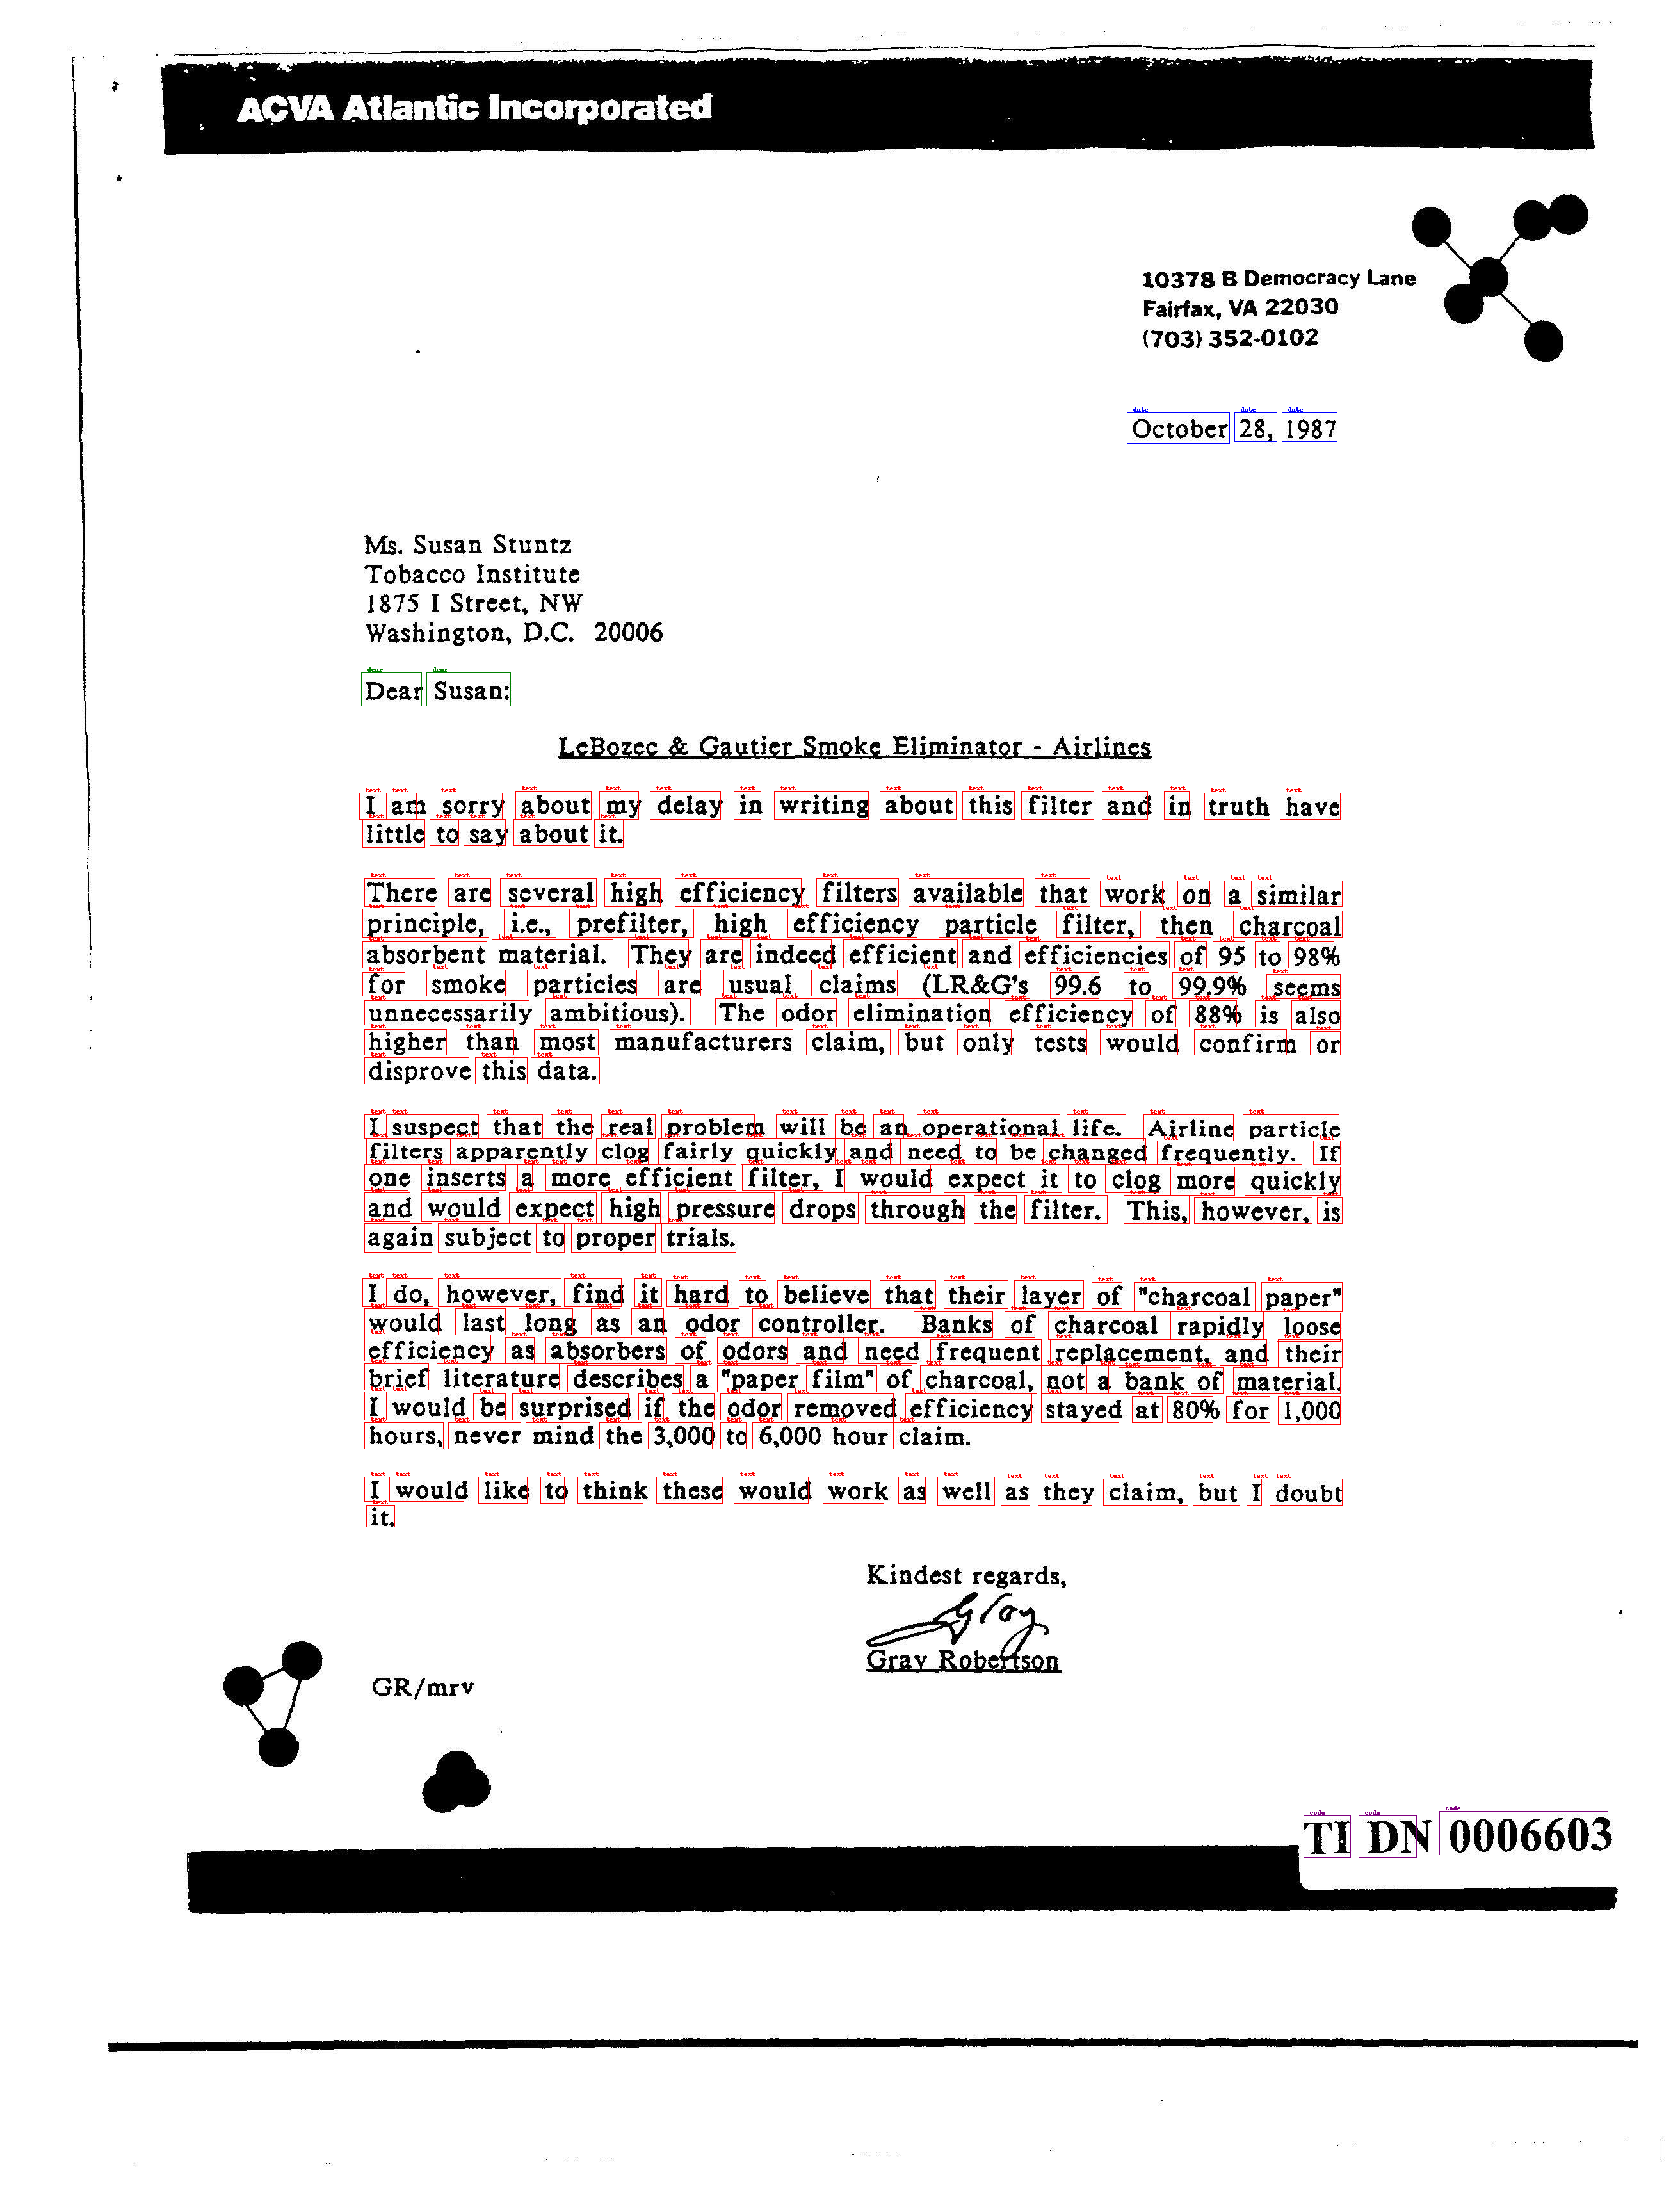

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(true_predictions, true_boxes, draw, image)
image

In [ ]:
# Stampare il risultato dell'OCR 
print("Dear:", " ".join([example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-Dear" or tag == "B-Dear"]))
print("Date:", " ".join([example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-Date" or tag == "B-Date"]))
print("text:", " ".join([example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-text" or tag == "B-text"]))
print("code:", " ".join([example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-code" or tag == "B-code"]))

Dear: Dear Susan:
Date: October 28, 1987
text: I am sorry about my delay in writing about this filter and in truth have little to say about it. There are several high efficiency filters available that work on a similar principle, i.e., prefilter, high efficiency particle filter, then charcoal absorbent material. They are indeed efficient and efficiencies of 95 to 98% for smoke particles are usual claims (LR&G's 99.6 to 99.9% seems unnecessarily ambitious). The odor elimination efficiency of 88% is also higher than most manufacturers claim, but only tests would confirm or disprove this data. I suspect that the real problem will be an operational life. Airline particle filters apparently clog fairly quickly and need to be changed frequently. If one inserts a more efficient filter, I would expect it to clog more quickly and would expect high pressure drops through the filter. This, however, is again subject to proper trials. I do, however, find it hard to believe that their layer of "char

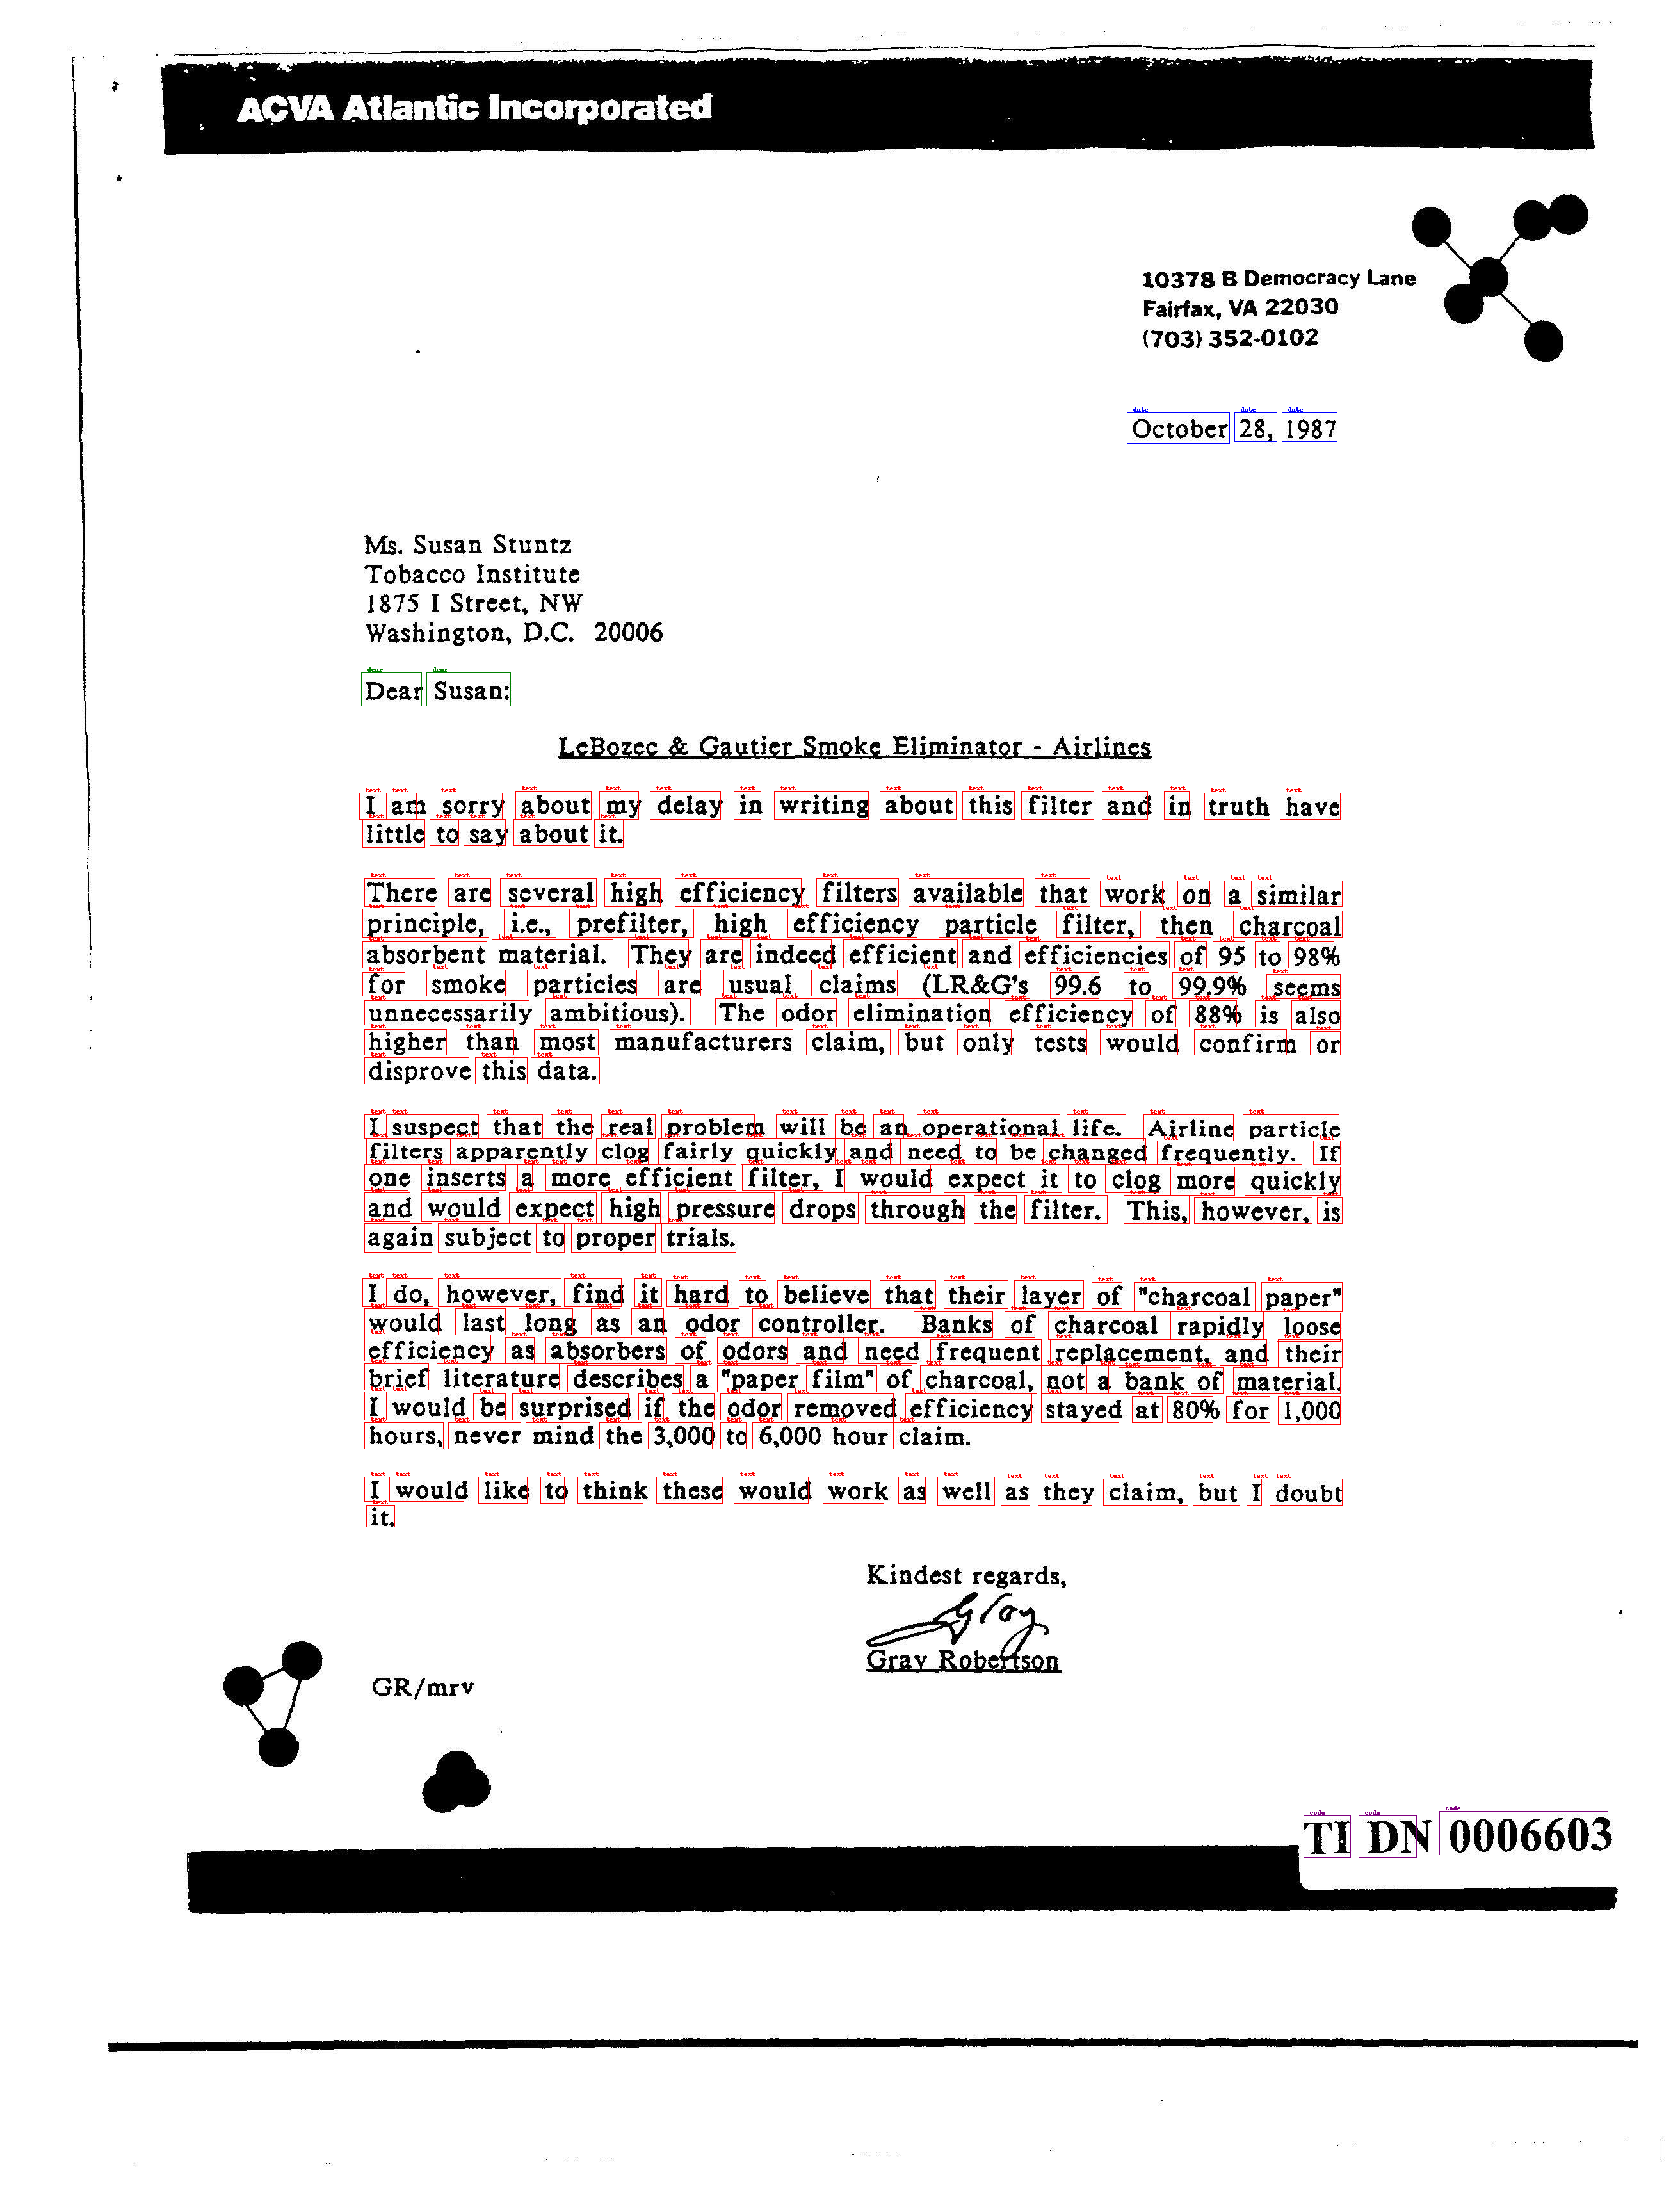

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(example['ner_tags'], example['bboxes'], draw, image, True)

image

In [ ]:
# Stampare il risultato dell'OCR 
print("Dear:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-Dear" or tag == "B-Dear"]))
print("Date:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-Date" or tag == "B-Date"]))
print("text:", " ".join([example["tokens"][i] for i, tag in enumerate(example["ner_tags"]) if tag == "I-text" or tag == "B-text"]))

Dear: Dear Mr. Ravlin:
Date: August 16, 1967
text: Thank you for the copy of your memorandum dated August 4, 1967 which was brought to my attention upon my return from vacation. Mr. William E. Duffy, our Tax Manager, will serve as Lorillard's representa- tive on the informal committee. I would suggest that your Mr. Bryant contact Mr. Duffy directly in arranging for the first meeting of the committee. I understand that Mr. Duffy will be attending a tax conference in Denver later this month and that might be an appro- priate time for the meeting.


In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(true_predictions, true_boxes, draw, image)
image.save("/Users/giuliamenichini/Downloads/lavoro/output/outputLetter.jpeg", "JPEG")

In [ ]:
# OCR result
dear_entities = [example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-Dear" or tag == "B-Dear"]
date_entities = [example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-Date" or tag == "B-Date"]
text_entities = [example["tokens"][i] for i, tag in enumerate(true_predictions) if tag == "I-text" or tag == "B-text"]

output_text = f"DEAR: {' '.join(dear_entities)}\n"
output_text += f"DATE: {' '.join(date_entities)}\n"
output_text += f"text: {' '.join(text_entities)}\n"


# Saving OCR in output.txt
output_file_path = "/Users/giuliamenichini/Downloads/lavoro/output/outputLetter.txt"
with open(output_file_path, "w") as output_file:
    output_file.write(output_text)

In [ ]:
#GROUND TRUTH
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(example['ner_tags'], example['bboxes'], draw, image, True)

image.save("/Users/giuliamenichini/Downloads/lavoro/output/outputGTLetter.jpeg", "JPEG")